In [1]:
import xarray as xr
import datetime
from pandas import DataFrame, read_csv, read_table
import geopandas as gpd
import pandas as pd
from pandas.tools.plotting import table
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import cartopy  # Map projections libary
import cartopy.crs as ccrs  # Projections list
import shapely.geometry as shpg
import seaborn as sns
import salem
from salem import get_demo_file, DataLevels, GoogleVisibleMap, Map
import scipy
from scipy import stats
from scipy.stats import norm
from scipy.ndimage.measurements import label as label_region
from scipy.ndimage.measurements import find_objects
from IPython.display import clear_output


%matplotlib inline

# The commands below are not important
import warnings
warnings.filterwarnings('ignore') 
sns.set_context('paper')

In [2]:
fdf = '/home/miri/Dokumente/data_peru/wet_data_sel_stat.csv'      # wet Data of selected stations
mdf = '/home/miri/Dokumente/data_peru/metadata_sel_stat_cor.csv'   # metadata of selected stations

In [16]:
# global parameters
wet_perc = 0.7
dry_perc = 0.3
ndays_dry = 5
ndays_wet = 3
st_perc = 0.5 # *100 = % of stations which needs to see the spell
month = [11,12,1,2,3]

In [17]:
# read the data
meta_df = pd.read_csv(mdf, index_col=0)
#meta_df
df_orig = pd.read_csv(fdf, index_col=0, parse_dates=True, dayfirst=True, na_values=-9999.00)

In [18]:
# compute rolling mean over 5 days for all stations
df = df_orig.rolling(window=5, center=True).mean()

In [19]:
# have a look only on the month of heavy rain, Oct/Nov/Dez - April/March
df = df.loc[np.in1d(df.index.month, month)]

In [20]:
# select the wet/dry quantiles per station
dry_quant = pd.Series(index=df.columns)
wet_quant = pd.Series(index=df.columns)
for c in df.columns:
    drop = df[c].dropna()
    dry_quant.loc[c] = drop.quantile(dry_perc)
    wet_quant.loc[c]= drop.quantile(wet_perc)

In [21]:
# process spells func
def _process_spell(st, st_true, df_spell, df_spell_nb, df_spell_stats, ndays_thres):
    r, nr = label_region(st_true)    
    nr = [i+1 for i, o in enumerate(find_objects(r)) if (len(r[o]) >= ndays_thres)]
    is_event = np.array([ri in nr for ri in r])
    # everywhere 0 where we have valid data
    st = st * 0.
    st.loc[is_event] = 1 # allocate 1 where there is a spell
    df_spell[c] = st
    # number
    st = st * 0.
    lab, _ = label_region(is_event) 
    st.loc[is_event] = lab[np.where(is_event)]
    df_spell_nb[c] = st
    # len
    st = st * 0.
    lenev = np.array([len(r[o]) for o in find_objects(lab[np.where(is_event)])]).astype(int)
    # df spell statistics
    df_spell_stats.loc['total_ndays', c] = len(st) # total number of days in time period
    df_spell_stats.loc['total_nvaliddays', c] = st.count() # total number of valid days in time period
    df_spell_stats.loc['nevents', c] = np.max(lab[np.where(is_event)]) # number of events 
    df_spell_stats.loc['mean_len', c] = np.mean(lenev) # average length of the events
    df_spell_stats.loc['median_len', c] = np.median(lenev) # median length of the events
    df_spell_stats.loc['min_len', c] = np.min(lenev) # minimum length of the events, like defined
    df_spell_stats.loc['max_len', c] = np.max(lenev) # maximum length of events 

In [22]:
dry_spell = pd.DataFrame(index=df.index)
dry_spell_nb = pd.DataFrame(index=df.index)
dry_spell_stats = pd.DataFrame(columns=df.columns)
for c, thres in dry_quant.iteritems():
    st = df[c]
    st_true = st <= thres
    _process_spell(st, st_true, dry_spell, dry_spell_nb, dry_spell_stats, ndays_dry)

In [23]:
wet_spell = pd.DataFrame(index=df.index)
wet_spell_nb = pd.DataFrame(index=df.index)
wet_spell_stats = pd.DataFrame(columns=df.columns)
for c, thres in wet_quant.iteritems():
    st = df[c]
    st_true = st >= thres
    _process_spell(st, st_true, wet_spell, wet_spell_nb, wet_spell_stats, ndays_wet)

In [24]:
dry_mean = dry_spell.mean(axis=1)
wet_mean = wet_spell.mean(axis=1)

In [13]:
#dry_mean

In [25]:
# Tage mit dry spell an min 50% der Stationen 
dry = dry_mean.loc[dry_mean>=st_perc]

In [14]:
#dry_mean>=st_perc

In [26]:
# process spells func
dry_true = dry_mean>=st_perc
    
r, nr = label_region(dry_true)    
nr = [i+1 for i, o in enumerate(find_objects(r)) if (len(r[o]) >= ndays_dry)]
is_event = np.array([ri in nr for ri in r])

dry_gl_sp = pd.DataFrame(index=df.index)
dry_gl_sp = dry_mean * 0.
dry_gl_sp.loc[is_event] = 1

# number
st = dry_mean * 0.
lab, _ = label_region(is_event) 
st.loc[is_event] = lab[np.where(is_event)]
dry_gl_nb = st

# len
st = dry_mean * 0.
dry_lenev = np.array([len(r[o]) for o in find_objects(lab[np.where(is_event)])]).astype(int)

In [27]:
dry_lenev

array([14, 12, 24,  6, 17,  9,  5, 18, 15,  6,  9,  5,  5,  5,  6, 11, 13,
       23,  6, 36, 30, 23, 43,  8,  9,  5, 34,  9,  6, 25,  7, 48, 10, 10,
       18, 11, 15, 16, 12, 11,  8, 45,  7,  7, 13, 11,  8,  5, 29, 20,  6,
        5, 10,  5, 10, 23,  9, 14, 21,  7,  9,  8,  6,  6,  5,  7, 23, 13,
        7,  8,  7,  6,  7, 31,  5,  6, 11, 17, 11,  7, 11,  6,  7,  9,  9,
        7,  5, 14,  6,  6,  5, 24, 13,  8, 15,  7,  7, 14])

In [28]:
# process spells func
wet_true = wet_mean>=st_perc
    
r, nr = label_region(wet_true)    
nr = [i+1 for i, o in enumerate(find_objects(r)) if (len(r[o]) >= ndays_wet)]
is_event = np.array([ri in nr for ri in r])

wet_gl_sp = pd.DataFrame(index=df.index)
wet_gl_sp = wet_mean * 0.
wet_gl_sp.loc[is_event] = 1

# number
st = wet_mean * 0.
lab, _ = label_region(is_event) 
st.loc[is_event] = lab[np.where(is_event)]
wet_gl_nb = st

# len
st = wet_mean * 0.
wet_lenev = np.array([len(r[o]) for o in find_objects(lab[np.where(is_event)])]).astype(int)

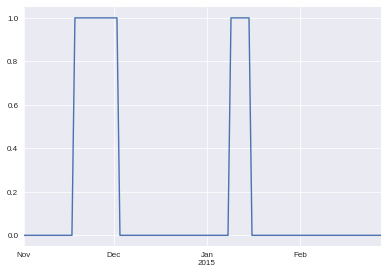

In [36]:
dry_gl_sp['2014-11':'2015-02'].plot();

In [37]:
dry_gl_nb['2014-11':'2014-12']

2014-11-01     0.0
2014-11-02     0.0
2014-11-03     0.0
2014-11-04     0.0
2014-11-05     0.0
2014-11-06     0.0
2014-11-07     0.0
2014-11-08     0.0
2014-11-09     0.0
2014-11-10     0.0
2014-11-11     0.0
2014-11-12     0.0
2014-11-13     0.0
2014-11-14     0.0
2014-11-15     0.0
2014-11-16     0.0
2014-11-17     0.0
2014-11-18    95.0
2014-11-19    95.0
2014-11-20    95.0
2014-11-21    95.0
2014-11-22    95.0
2014-11-23    95.0
2014-11-24    95.0
2014-11-25    95.0
2014-11-26    95.0
2014-11-27    95.0
2014-11-28    95.0
2014-11-29    95.0
2014-11-30    95.0
              ... 
2014-12-02    95.0
2014-12-03     0.0
2014-12-04     0.0
2014-12-05     0.0
2014-12-06     0.0
2014-12-07     0.0
2014-12-08     0.0
2014-12-09     0.0
2014-12-10     0.0
2014-12-11     0.0
2014-12-12     0.0
2014-12-13     0.0
2014-12-14     0.0
2014-12-15     0.0
2014-12-16     0.0
2014-12-17     0.0
2014-12-18     0.0
2014-12-19     0.0
2014-12-20     0.0
2014-12-21     0.0
2014-12-22     0.0
2014-12-23  

In [39]:
dry_gl_nb.max()

98.0

In [40]:
dry_spell['2014-11':'2014-12']

,154108_RR,154107_RR,000445_RR,000538_RR,154113_RR,150901_RR,150903_RR,150902_RR,155105_RR,150904_RR,154110_RR,000443_RR,000441_RR,154111_RR,000444_RR,155407_RR
2014-11-01,1.0,0.0,1.0,1.0,NaN,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,NaN
2014-11-02,1.0,0.0,1.0,1.0,NaN,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,NaN
2014-11-03,1.0,0.0,1.0,1.0,NaN,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,NaN
2014-11-04,1.0,0.0,0.0,1.0,NaN,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,NaN
2014-11-05,0.0,0.0,0.0,1.0,NaN,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,NaN
2014-11-06,0.0,0.0,0.0,1.0,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,NaN
2014-11-07,0.0,0.0,0.0,1.0,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,NaN
2014-11-08,0.0,0.0,0.0,1.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2014-11-09,0.0,0.0,0.0,1.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2014-11-10,0.0,0.0,0.0,1.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


87.0


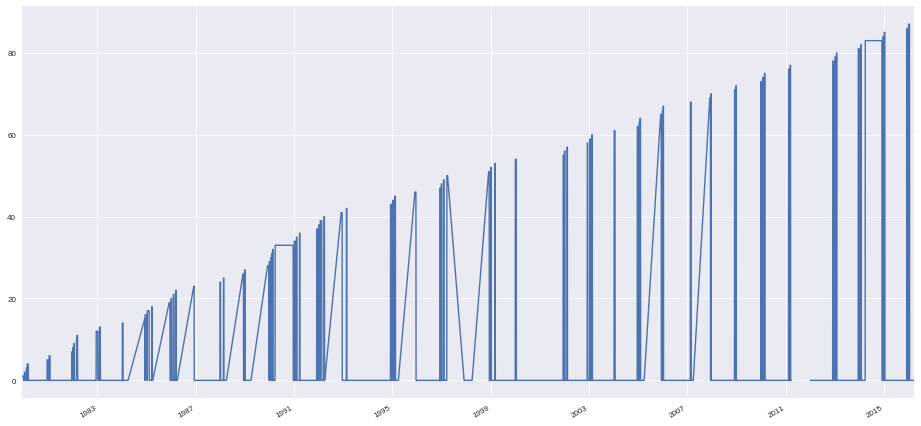

In [19]:
print(dry_gl_nb.max())
dry_gl_nb.plot(figsize=(16,8))

in the 36 wet seasons are 87 dry spells with at least 5 days duration and less than the stations 30th quantile. This means that in average there are 2 per wet season.

124.0


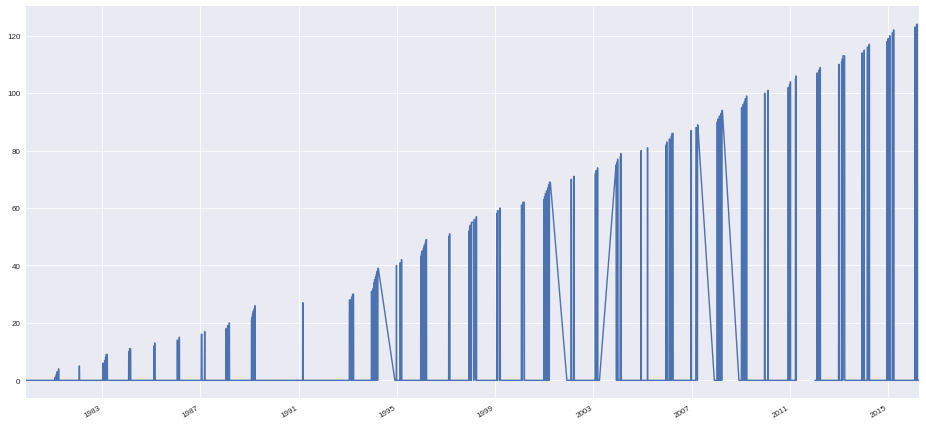

In [20]:
print(wet_gl_nb.max())
wet_gl_nb.plot(figsize=(16,8))

in the 36 wet seasons are 124 wet spells with at least 3 days duration and more than the stations 70th quantile. This means that in average there are 3-4 per wet season.

In [66]:
# checking if i have spells as well where Marias is working on
dry_gl_sp['2015-01']


2015-01-01    0.0
2015-01-02    0.0
2015-01-03    0.0
2015-01-04    0.0
2015-01-05    0.0
2015-01-06    1.0
2015-01-07    1.0
2015-01-08    1.0
2015-01-09    1.0
2015-01-10    1.0
2015-01-11    1.0
2015-01-12    1.0
2015-01-13    1.0
2015-01-14    1.0
2015-01-15    1.0
2015-01-16    0.0
2015-01-17    0.0
2015-01-18    0.0
2015-01-19    0.0
2015-01-20    0.0
2015-01-21    0.0
2015-01-22    0.0
2015-01-23    0.0
2015-01-24    0.0
2015-01-25    0.0
2015-01-26    0.0
2015-01-27    0.0
2015-01-28    0.0
2015-01-29    0.0
2015-01-30    0.0
2015-01-31    0.0
dtype: float64

In [68]:
wet_gl_sp['2015-02-25':'2015-03-10']

2015-02-25    0.0
2015-02-26    0.0
2015-02-27    0.0
2015-02-28    1.0
2015-03-01    1.0
2015-03-02    1.0
2015-03-03    1.0
2015-03-04    1.0
2015-03-05    1.0
2015-03-06    0.0
2015-03-07    0.0
2015-03-08    0.0
2015-03-09    0.0
2015-03-10    0.0
dtype: float64

In [92]:
ds = xr.open_mfdataset('/media/miri/Seagate Backup Plus Drive/Miriam/daily/era-int-SA-pl-daily_*.nc')

In [72]:
# looking at the dry spells of 1980 Jan-Mar
dry_gl_sp['1980-01-01':'1980-03-31'].sum()
ds_true = np.in1d(dry_gl_sp['1980-01-01':'1980-03-31'],1)
time_spell = ds.time.isel(time=ds_true)
time=np.in1d(ds.time, time_spell)
dss_dry = ds.sel(time=np.in1d(ds.time, time_spell))

In [71]:
#dss_dry

In [65]:
dss.to_netcdf('/home/miri/Dokumente/Master/MA/Dry_Spells_1980.nc')

In [80]:
wet_test = wet_gl_sp['1981-01-01':'1981-03-31'].sum()
ds_true = np.in1d(wet_gl_sp['1981-01-01':'1981-03-31'],1)
time_spell = ds.time.isel(time=ds_true)
time=np.in1d(ds.time, time_spell)
dss_wet = ds.sel(time=np.in1d(ds.time, time_spell))

In [81]:
ds_true

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
       False, False, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False, False, False, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True,  True,  True,  True, False, False, False], dtype=bool)

In [82]:
dss_wet

<xarray.Dataset>
Dimensions:    (latitude: 68, level: 12, longitude: 162, time: 39)
Coordinates:
  * longitude  (longitude) float32 229.5 230.25 231.0 231.75 232.5 233.25 ...
  * latitude   (latitude) float32 20.25 19.5 18.75 18.0 17.25 16.5 15.75 ...
  * level      (level) int32 100 200 300 400 500 600 700 800 850 900 950 1000
  * time       (time) datetime64[ns] 1980-01-28 1980-01-29 1980-01-30 ...
Data variables:
    r          (time, level, latitude, longitude) float32 28.0837 28.6134 ...
    v          (time, level, latitude, longitude) float32 1.70167 2.10866 ...
    q          (time, level, latitude, longitude) float32 1.69903e-06 ...
    u          (time, level, latitude, longitude) float32 18.6854 18.9874 ...
    t          (time, level, latitude, longitude) float32 197.082 196.879 ...
    w          (time, level, latitude, longitude) float32 -0.011718 ...
    z          (time, level, latitude, longitude) float32 161420.0 161423.0 ...

In [83]:
dss_wet.to_netcdf('/home/miri/Dokumente/Master/MA/Wet_Spells_1981.nc')

In [93]:
ds_true = np.in1d(dry_gl_sp,1)

In [94]:
len(ds_true)

4487

In [95]:
time_spell = ds.time.isel(time=ds_true)

In [96]:
# looking at the dry spells of 1980 Jan-Mar
#dry_gl_sp['1980-01-01':'1980-03-31'].sum()
ds_true = np.in1d(dry_gl_sp,1)
time_spell = ds.time.isel(time=ds_true)
time=np.in1d(ds.time, time_spell)
dss_dry = ds.sel(time=np.in1d(ds.time, time_spell))

In [98]:
dss_dry.to_netcdf('/media/miri/Seagate Backup Plus Drive/Miriam/Daily_dry_spells.nc')

In [100]:
ds_true = np.in1d(wet_gl_sp,1)
time_spell = ds.time.isel(time=ds_true)
time=np.in1d(ds.time, time_spell)
dss_wet = ds.sel(time=np.in1d(ds.time, time_spell))
dss_wet.to_netcdf('/media/miri/Seagate Backup Plus Drive/Miriam/Daily_wet_spells.nc')